In [10]:
from ego_graph_dataset import select_active_graph
from tqdm import tqdm
import pandas as pd
import os
from utils import scores2coalition
from utils import to_networkx

import utils
from gspan_mine.gspan_mining.config import parser
from gspan_mine.gspan_mining.main import main

In [11]:
number_of_graph_per_rule = utils.MUTAGENICITY_NUMBER_OF_GRAPH_PER_RULE

In [12]:
# Build the graph.data file for a given rule
def build_graph_data(dataset='mutagenicity' ,rule=1, metric='entropy', node_selection='fixed_size', nb_graph=2923):
    graphs = select_active_graph(f'./activ_ego/mutag_{rule}labels_egos.txt', 2,0,[])
    skipped_index = []
    with open(f'results/{dataset}_{rule}_{metric}_{node_selection}.data', 'w+') as f:
        for i in tqdm(range(nb_graph)):
            graph = to_networkx(graphs[i], to_undirected=True, node_attrs=['center', 'x'])
            df_node_score = pd.read_csv(os.path.join("./results/mutagenicity/gcn/gstarx",
                             f"rule_{rule}/result_{dataset}_{rule}_{i}.csv"))
            if df_node_score is None or len(df_node_score) == 0:
                skipped_index.append(i)
                continue
            node_score = df_node_score[metric].values
            coalition = scores2coalition(node_score, sparsity=0.5, fixed_size=True, size=3)
            # If the node that has the label 'center' to True in the graph is not in the coalition, add it
            for node in graph.nodes():
                if graph.nodes[node]['center'] and node not in coalition:
                    coalition.append(node)
            # Select the subgraph induce by the coalition
            subgraph = graph.subgraph(coalition)
            f.write(f't # {i}\n')
            for node in subgraph.nodes():
                f.write(f'v {int(node)} {graph.nodes[node]["x"]}\n')
            for edge in subgraph.edges():
                f.write(f'e {int(edge[0])} {int(edge[1])} 0\n')
    print(f"Skipped {len(skipped_index)} graphs")

In [13]:
# Build the graph.data file for a given rule
def build_graph_data_neighbors(dataset='mutagenicity' ,rule=1, metric='entropy', node_selection='fixed_size',nb_graph=2923):
    graphs = select_active_graph(f'./activ_ego/mutag_{rule}labels_egos.txt', 2,0,[])
    skipped_index = []
    with open(f'results/{dataset}_{rule}_{metric}_{node_selection}_with_neighbors.data', 'w+') as f:
        for i in tqdm(range(nb_graph)):
            try:
                graph = to_networkx(graphs[i], to_undirected=True, node_attrs=['center', 'x'])
            except Exception as e:
                print(e)
                skipped_index.append(i)
                continue
            df_node_score = pd.read_csv(os.path.join("./results/mutagenicity/gcn/gstarx",
                             f"rule_{rule}/result_{dataset}_{rule}_{i}.csv"))
            if df_node_score is None or len(df_node_score) == 0:
                skipped_index.append(i)
                continue
            node_score = df_node_score[metric].values
            coalition = scores2coalition(node_score, sparsity=0.5, fixed_size=True, size=3)
            # If the node that has the label 'center' to True in the graph is not in the coalition, add it
            for node in graph.nodes():
                if graph.nodes[node]['center'] and node not in coalition:
                    coalition.append(node)
            # Select the subgraph induce by the coalition
            # Add direct neighbors of the coalition to the coalition without adding nodes that are already in the coalition
            for node in coalition:
                for neighbor in graph.neighbors(node):
                    if neighbor not in coalition:
                        coalition.append(neighbor)
            subgraph = graph.subgraph(coalition)
            f.write(f't # {i}\n')
            for node in subgraph.nodes():
                f.write(f'v {int(node)} {graph.nodes[node]["x"]}\n')
            for edge in subgraph.edges():
                f.write(f'e {int(edge[0])} {int(edge[1])} 0\n')
    print(f"Skipped {len(skipped_index)} graphs")

In [14]:
def gspan_mine_rule(rule=1, metric='entropy', node_selection='split_top', with_neighbors=False, supp_ratio=0.9, dataset='mutagenicity'):
    if with_neighbors:
        build_graph_data_neighbors(dataset, rule, metric, node_selection, nb_graph=number_of_graph_per_rule[rule])
    else:
        build_graph_data(dataset, rule, metric, node_selection, nb_graph=number_of_graph_per_rule[rule])
    nb_graph = number_of_graph_per_rule[rule]
    min_support = int(nb_graph * supp_ratio)
    args_str = f'-s {min_support} -p True -d False ./results/{dataset}_{rule}_{metric}_{node_selection}{"_with_neighbors" if with_neighbors else ""}.data'
    FLAGS, _ = parser.parse_known_args(args=args_str.split())
    gs = main(FLAGS)
    return gs

Number of graphs: 2923


100%|██████████| 2923/2923 [00:03<00:00, 817.30it/s]


Skipped 14 graphs
Dataset: mutagenicity
Label dict: {0: 'C', 1: 'O', 2: 'Cl', 3: 'H', 4: 'N', 5: 'F', 6: 'Br', 7: 'S', 8: 'P', 9: 'I', 10: 'Na', 11: 'K', 12: 'Li', 13: 'Ca'}
t # 0
v 0 0
v 1 4
e 0 1 0

Support: 2811


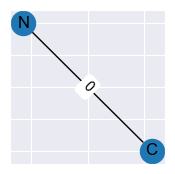


-----------------

Read:	0.04 s
Mine:	0.30000000000000004 s
Total:	0.34 s


In [15]:
gspan_mine_rule(rule=1, with_neighbors=True, supp_ratio=0.9)

For some rule, we need to reduce the support ratio

Number of graphs: 5915


100%|██████████| 5915/5915 [00:07<00:00, 789.89it/s]


Skipped 0 graphs
Dataset: mutagenicity
Label dict: {0: 'C', 1: 'O', 2: 'Cl', 3: 'H', 4: 'N', 5: 'F', 6: 'Br', 7: 'S', 8: 'P', 9: 'I', 10: 'Na', 11: 'K', 12: 'Li', 13: 'Ca'}
t # 0
v 0 1
v 1 4
e 0 1 0

Support: 3005


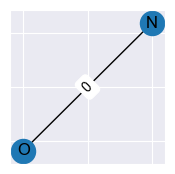


-----------------

Read:	0.2 s
Mine:	0.19 s
Total:	0.39 s


In [16]:
gspan_mine_rule(rule=9, with_neighbors=True, supp_ratio=0.5)

Number of graphs: 1440


100%|██████████| 1440/1440 [00:02<00:00, 640.05it/s]


Skipped 14 graphs
Dataset: mutagenicity
Label dict: {0: 'C', 1: 'O', 2: 'Cl', 3: 'H', 4: 'N', 5: 'F', 6: 'Br', 7: 'S', 8: 'P', 9: 'I', 10: 'Na', 11: 'K', 12: 'Li', 13: 'Ca'}
t # 0
v 0 0
v 1 0
e 0 1 0

Support: 1404


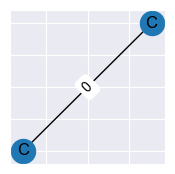


-----------------

t # 1
v 0 0
v 1 0
v 2 0
e 0 1 0
e 1 2 0

Support: 1402


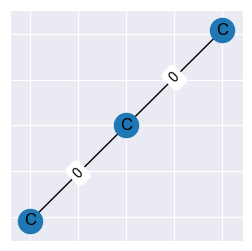


-----------------

Read:	0.03 s
Mine:	0.35 s
Total:	0.38 s


In [17]:
gspan_mine_rule(rule=12, with_neighbors=True, supp_ratio=0.9)

Number of graphs: 4278


100%|██████████| 4278/4278 [00:06<00:00, 700.77it/s]


Skipped 0 graphs
Dataset: mutagenicity
Label dict: {0: 'C', 1: 'O', 2: 'Cl', 3: 'H', 4: 'N', 5: 'F', 6: 'Br', 7: 'S', 8: 'P', 9: 'I', 10: 'Na', 11: 'K', 12: 'Li', 13: 'Ca'}
t # 0
v 0 0
v 1 0
e 0 1 0

Support: 4264


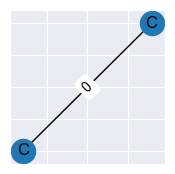


-----------------

t # 1
v 0 0
v 1 0
v 2 0
e 0 1 0
e 1 2 0

Support: 4244


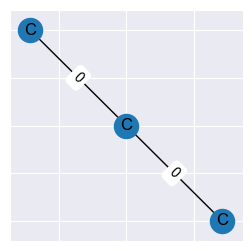


-----------------

t # 2
v 0 0
v 1 0
v 2 0
v 3 3
e 0 1 0
e 1 2 0
e 1 3 0

Support: 4195


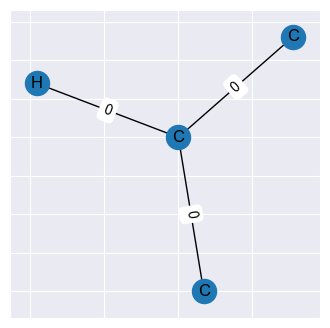


-----------------

t # 3
v 0 0
v 1 0
v 2 0
v 3 0
e 0 1 0
e 1 2 0
e 2 3 0

Support: 3952


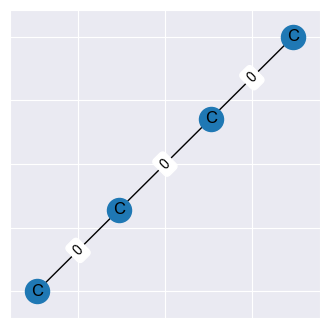


-----------------

t # 4
v 0 0
v 1 0
v 2 0
v 3 0
v 4 3
e 0 1 0
e 1 2 0
e 2 3 0
e 2 4 0

Support: 3940


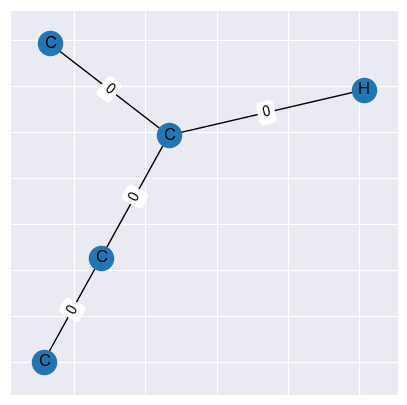


-----------------

t # 5
v 0 0
v 1 0
v 2 0
v 3 3
e 0 1 0
e 1 2 0
e 2 3 0

Support: 4241


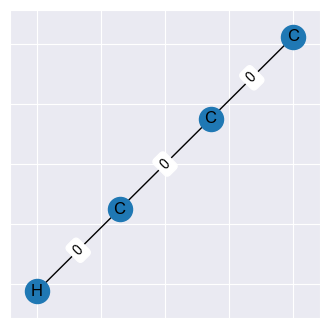


-----------------

t # 6
v 0 0
v 1 0
v 2 3
e 0 1 0
e 1 2 0

Support: 4264


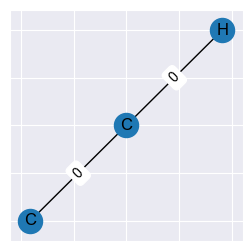


-----------------

t # 7
v 0 0
v 1 3
e 0 1 0

Support: 4278


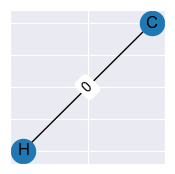


-----------------

Read:	0.32 s
Mine:	4.09 s
Total:	4.41 s


In [19]:
gspan_mine_rule(rule=23, with_neighbors=True, supp_ratio=0.9)

Number of graphs: 4486


100%|██████████| 4486/4486 [00:06<00:00, 650.46it/s]


Skipped 222 graphs
Dataset: mutagenicity
Label dict: {0: 'C', 1: 'O', 2: 'Cl', 3: 'H', 4: 'N', 5: 'F', 6: 'Br', 7: 'S', 8: 'P', 9: 'I', 10: 'Na', 11: 'K', 12: 'Li', 13: 'Ca'}
t # 0
v 0 0
v 1 0
e 0 1 0

Support: 4251


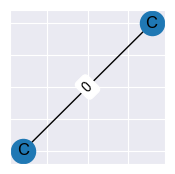


-----------------

t # 1
v 0 0
v 1 0
v 2 0
e 0 1 0
e 1 2 0

Support: 4231


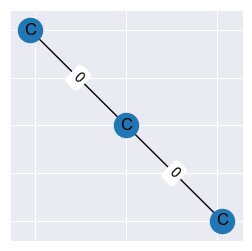


-----------------

Read:	0.36 s
Mine:	1.8600000000000003 s
Total:	2.22 s


In [20]:
gspan_mine_rule(rule=25, with_neighbors=True, supp_ratio=0.9)